# Real time demo - trigger word detection
Modified from https://github.com/Tony607/Keras-Trigger-Word.git


In [ ]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op

import numpy as np
import time
# from pydub import AudioSegment
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob

# from td_utils import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write

import IPython
import IPython.display as ipd

%matplotlib inline

In [ ]:
# # Use 1101 for 2sec input audio
# Tx = 16 # The number of time steps input to the model from the spectrogram
# num_filters = n_freq = 40 # Number of frequencies input to the model at each time step of the spectrogram

# model_file = 'kws_ufe_15mar2022.h5'
# i16min = -2**15
# i16max = 2**15-1
# fsamp = fs
# wave_length_ms = 1000
# wave_length_samps = int(wave_length_ms*fsamp/1000)
# window_size_ms=80
# window_step_ms=60
# use_microfrontend = True


model_file = 'kws_ufe_23mar2022_1821.h5'
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
label_list        = ['_silence', '_unknown', 'left', 'right']
spectrogram_shape = (1, 24, 32, 1)

Tx = spectrogram_shape[1] # The number of time steps input to the model from the spectrogram
num_filters = n_freq = spectrogram_shape[2] # Number of frequencies input to the model at each time step of the spectrogram


## Load a pre-train model

In [ ]:
# tf.compat.v1.disable_v2_behavior() # Needed if model trained in tf1
# model = tf.compat.v1.keras.models.load_model('./models/tr_model.h5')

model = tf.keras.models.load_model(model_file)
print(f"Model input is: {model.input.shape}")
model.summary()

OSError: ignored

In [ ]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


### Test model on static input

In [ ]:
# Download the speech_commands dataset

DATASET_PATH = 'data/speech_commands_files_0.2'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      # origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True, cache_dir='.', cache_subdir='data/speech_commands_files_0.2')
  

In [ ]:
!ls $wav_dir | head -n 20

Fsamp = 16000.  wav shape = (16000,)
spec shape = (24, 32)


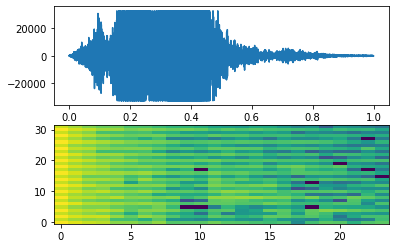

In [ ]:
wav_dir = os.path.join('data/speech_commands_files_0.2/sheila/')
wav_file = os.path.join(wav_dir, '2144be19_nohash_0.wav')
                        
fs, test_wav = wavfile.read(wav_file)
print(f"Fsamp = {fs}.  wav shape = {test_wav.shape}")

test_spec = get_spectrogram(test_wav)
print(f"spec shape = {test_spec.shape}")
plt.subplot(2,1,1)
plt.plot(np.arange(len(test_wav))/fs, test_wav)
plt.subplot(2,1,2)
plt.imshow(test_spec.numpy().T, aspect='auto', origin='lower', interpolation='none')
ipd.Audio(test_wav, rate=fs)

In [ ]:
label_list = ['_silence', '_unknown', 'left', 'right']
y = model.predict(np.expand_dims(test_spec, [0,-1]))
print(f"Classification = {label_list[np.argmax(y)]}")

Classification = left


### Detect trigger word functions

In [ ]:
def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.
    
    Argument:
    x -- spectrum of shape (freqs, Tx)
    i.e. (Number of frequencies, The number time steps)

    Returns:
    predictions -- flattened numpy array to shape (number of output time steps)
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    It is looking for the rising edge of the predictions data belongs to the
    last/latest chunk.
    
    Argument:
    predictions -- predicted labels from model
    chunk_duration -- time in second of a chunk
    feed_duration -- time in second of the input to model
    threshold -- threshold for probability above a certain to be considered positive

    Returns:
    True if new trigger word detected in the latest chunk
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False
    
    

# Record audio stream from mic

In [ ]:
chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

### Audio stream

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!pip install PyAudio

In [ ]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time

In [ ]:
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 1 

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

print("pyAudio")
x = input()

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()

print("try")
x = input()

try:
    while run:
        data = q.get()

except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        

print("stream")
x = input()

stream.stop_stream()
stream.close()

pyAudio
a


In [ ]:
stream.stop_stream()
stream.close()

In [ ]:
plt.plot(np.arange(1*fs)/fs, data)

In [ ]:
n=1
print(data.shape)
ipd.Audio(data, rate=fs)# [n:n+int(fs)]
right_wav = data.copy()

In [ ]:

right_spec = get_spectrogram(right_wav)
print(right_spec.shape)
plt.imshow(right_spec.numpy().T)

In [ ]:

print(model.input.shape)
print(right_spec.shape)
xx = np.expand_dims(right_spec, [0,-1])
yy = model.predict(xx)
pred_str = label_list[np.argmax(yy)]
print(f"Classified as \'{pred_str}\'")


In [ ]:
# right_spec_bak = right_spec.numpy().copy()

## Test it streaming

In [ ]:
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 250

# Run the demo for a timeout seconds
timeout = time.time() + 10

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold 

    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('_')
        # return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('*')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)


stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()

try:
    while run:
        new_samples = q.get()
        mean_abs = np.abs(new_samples).mean()
        # print(f"Mean abs val = {mean_abs}")
        if mean_abs >= silence_threshold:
            spectrum = get_spectrogram(new_samples)
            spectrum = np.expand_dims(spectrum, [0,-1])
            yy = model.predict(spectrum)
            pred_str = label_list[np.argmax(yy)]
            print(f"Detected {pred_str}")
        
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()